# Introduction
## Automated Feature Selection using Python

This notebook demonstrates how to automate feature selection using various methods like correlation analysis, mutual information, Recursive Feature Elimination (RFE), and tree-based feature importance.

Selecting the right features can improve model performance, reduce overfitting, and save computational time.

We'll use the Titanic dataset (or any tabular dataset) to demonstrate each method.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Load and Preprocess Dataset

In [3]:
# Load Titanic dataset
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [11]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def preprocess_titanic_data(df, drop_cols=None, bool_cols=None, label_cols=None, dropna=True):
    """
    Cleans and preprocesses the Titanic dataset.
    
    Args:
        df (pd.DataFrame): Raw Titanic dataframe.
        drop_cols (list): Columns to drop.
        bool_cols (list): Boolean columns to convert to int.
        label_cols (list): Object columns to label encode.
        dropna (bool): Whether to drop rows with missing values.

    Returns:
        pd.DataFrame: Cleaned dataframe
        dict: Dictionary of fitted LabelEncoders
    """
    df = df.copy()

    # Drop specified columns
    if drop_cols:
        df.drop(drop_cols, axis=1, inplace=True)
    
    # Drop rows with NA
    if dropna:
        df.dropna(inplace=True)

    # Convert boolean columns to integers
    if bool_cols:
        df[bool_cols] = df[bool_cols].astype(int)

    # Encode object columns
    le_dict = {}
    if label_cols:
        for col in label_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            le_dict[col] = le

    return df, le_dict


# ======= Apply preprocessing =======
df_raw = sns.load_dataset('titanic')

drop_columns = ['deck', 'embark_town', 'class', 'who']   # dropping redundant or incomplete columns
bool_columns = ['adult_male', 'alone']
label_columns = ['sex', 'embarked', 'alive']

df_cleaned, encoders = preprocess_titanic_data(
    df=df_raw,
    drop_cols=drop_columns,
    bool_cols=bool_columns,
    label_cols=label_columns,
    dropna=True
)

# Quick look at processed data
df_cleaned.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,1,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,1,0
2,1,3,0,26.0,0,0,7.9250,2,0,1,1
3,1,1,0,35.0,1,0,53.1000,2,0,1,0
4,0,3,1,35.0,0,0,8.0500,2,1,0,1


## Split Features and Target

In [12]:
# Split into features and target
X = df_cleaned.drop('survived', axis=1)
y = df_cleaned['survived']

## Method 1: Correlation-Based Feature Selection

Highly correlated features often provide redundant information. We remove one of each pair with correlation > 0.8 to reduce multicollinearity and simplify the model.

In [13]:
# Step 1: Compute correlation matrix
corr_matrix = X.corr().abs()

# Step 2: Upper triangle of the matrix (no duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Drop features with high correlation
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Features to drop due to correlation > {threshold}:\n", to_drop)


Features to drop due to correlation > 0.8:
 ['adult_male']


In [14]:
# remove it from dataset
X_filtered = X.drop(columns=to_drop)

## Method 2: Mutual Information

Mutual Information measures how much knowing a feature reduces uncertainty about the target variable. It works well for both linear and non-linear relationships.

Higher scores indicate greater predictive power. We use it to rank features based on their information gain with respect to the target.

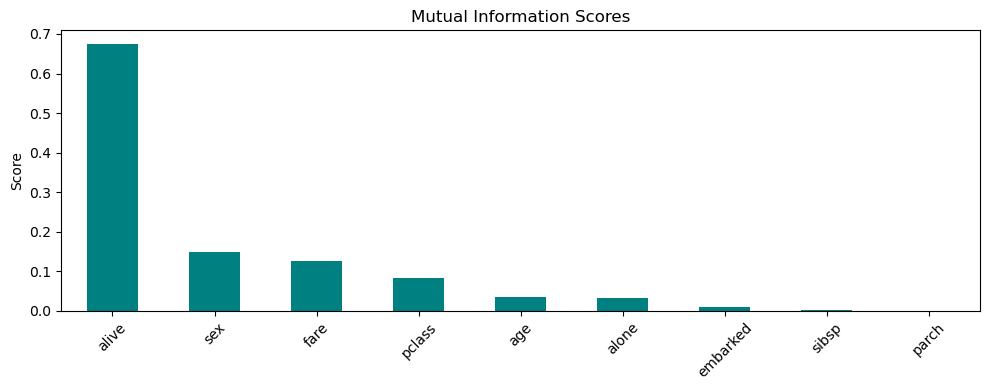

Top 5 features based on Mutual Information:
alive     0.675495
sex       0.147802
fare      0.126083
pclass    0.082422
age       0.035732
dtype: float64


In [15]:
# Compute mutual information scores
mi_scores = mutual_info_classif(X_filtered, y, random_state=42)

# Convert to Series for readability
mi_series = pd.Series(mi_scores, index=X_filtered.columns).sort_values(ascending=False)

# Plot the scores
plt.figure(figsize=(10, 4))
mi_series.plot(kind='bar', color='teal')
plt.title("Mutual Information Scores")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display top features
print("Top 5 features based on Mutual Information:")
print(mi_series.head())

## Method 3: Recursive Feature Elimination (RFE)

RFE recursively removes the least important features based on model coefficients or feature importance until the desired number of features is reached.

We use Logistic Regression as our base model and select the top 5 most informative features.

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Use Logistic Regression as the estimator
estimator = LogisticRegression(max_iter=1000, random_state=42)

# Define RFE to select top 5 features
rfe_selector = RFE(estimator=estimator, n_features_to_select=5)

# Fit the RFE model
rfe_selector.fit(X_filtered, y)

# Get the selected features
rfe_selected = X_filtered.columns[rfe_selector.support_]
print("Top 5 features selected by RFE:")
print(list(rfe_selected))

Top 5 features selected by RFE:
['pclass', 'sex', 'sibsp', 'alive', 'alone']


## Method 4: Tree-Based Feature Importance

Random Forests calculate feature importances during training by measuring how much each feature reduces uncertainty in the splits.

This method captures both linear and non-linear relationships and helps rank features effectively.

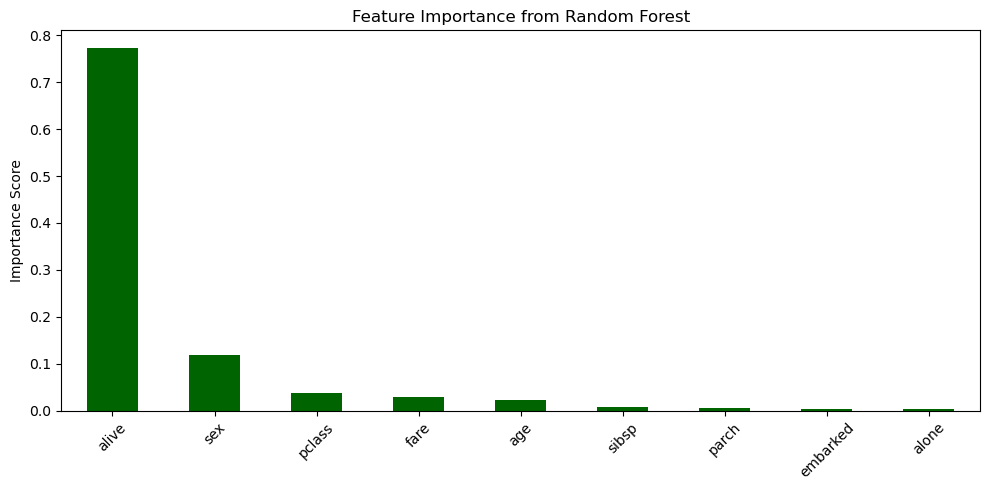

Top 5 features by Tree-Based Importance:
alive     0.771813
sex       0.118889
pclass    0.038467
fare      0.029215
age       0.022354
dtype: float64


In [17]:
# Step 1: Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_filtered, y)

# Step 2: Extract feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_filtered.columns)
importances = importances.sort_values(ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', color='darkgreen')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Print top features
print("Top 5 features by Tree-Based Importance:")
print(importances.head())

## Why Did We Use Random Forest for Feature Importance?

We chose **Random Forest** for feature importance because it provides a strong balance of simplicity, accuracy, and interpretability. Here's why it was preferred over other tree-based models:

###  Why Random Forest?
| Criteria | Why It Matters |
|---------|----------------|
| **Built-in feature importance** | Easily accessible via `.feature_importances_` |
| **Reduces overfitting** | Uses an ensemble of decision trees for more stable rankings |
| **Performs well with default settings** | No heavy hyperparameter tuning needed |
| **Handles both linear and non-linear patterns** | Captures complex relationships between features and target |

---

###  What About Other Tree-Based Models?

| Model | Can We Use It? | Why We Didn’t (Yet) |
|-------|----------------|---------------------|
| **Decision Tree** | Yes | Simpler, but results can be unstable due to high variance |
| **XGBoost / LightGBM** |  Yes | More powerful, but require more setup and tuning |
| **ExtraTrees** |  Yes | Works similarly to RF, but adds randomness which may reduce consistency |
